<a href="https://colab.research.google.com/github/douglasmmachado/MedicineConsumption/blob/main/notebooks/causal_method/unified_approach/3_Feature_Manipulation_and_Comprehension.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3 - Understanding feautures and selecting the most important ones regarding the consumption



---



---



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import math as m

df_url ="https://raw.githubusercontent.com/douglasmmachado/ExploratoryDataAnalysis/main/datasets/unified_approach/df_resampled.csv"

df = pd.read_csv(df_url)

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4072 entries, 0 to 4071
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   HOSPI_CODE_UCD            4072 non-null   int64  
 1   MONTH                     4072 non-null   int64  
 2   QUANTITY                  4072 non-null   float64
 3   N_UFS                     4072 non-null   float64
 4   N_ETB                     4072 non-null   float64
 5   POPULATION                4072 non-null   float64
 6   P_MEDICAL                 4072 non-null   float64
 7   PN_MEDICAL                4072 non-null   float64
 8   LIT_HC                    4072 non-null   float64
 9   LIT_HP                    4072 non-null   float64
 10  SEJ_MCO                   4072 non-null   float64
 11  SEJ_HAD                   4072 non-null   float64
 12  SEJ_PSY                   4072 non-null   float64
 13  SEJ_SSR                   4072 non-null   float64
 14  SEJ_SLD 

## 3.1 - Create moving average feature based on medicine

In [3]:
def calculate_moving_average(df, column, period):
    df_copy = df.copy()  # Create a copy of the DataFrame to avoid modifying the original

    for medicine in df_copy['HOSPI_CODE_UCD'].unique():
        mask = df_copy['HOSPI_CODE_UCD'] == medicine
        ma_column = column + '_MA'

        # Calculate the moving average
        vector = df_copy.loc[mask, column].values
        moving_average = np.zeros_like(vector)

        # Calculate the moving average for each index in the vector
        for i in range(len(vector)):
            start = max(0, i - period + 1)
            end = i + 1
            moving_average[i] = np.nanmean(vector[start:end])

        df_copy.loc[mask, ma_column] = moving_average /  np.linalg.norm(moving_average)

    return df_copy

In [4]:
def scatterplot_quantity(df, column, period):
    plt.figure(figsize=(15, 8))
    colors = plt.cm.viridis(np.linspace(0, 1, len(df['HOSPI_CODE_UCD'].unique())))

    for i, code in enumerate(df['HOSPI_CODE_UCD'].unique()):
        subset = df[df['HOSPI_CODE_UCD'] == code]
        plt.plot(subset[column], marker='o', linewidth=0.5, color=colors[i], label=code)

    plt.xlabel('Samples')
    plt.ylabel('Quantity')
    plt.title('Scatter Plot of Quantity moving average for the period of: ' + f'{period} months' )
    plt.xticks(rotation=45)
    plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), title='HOSPI_CODE_UCD')
    plt.grid(True)
    plt.show()

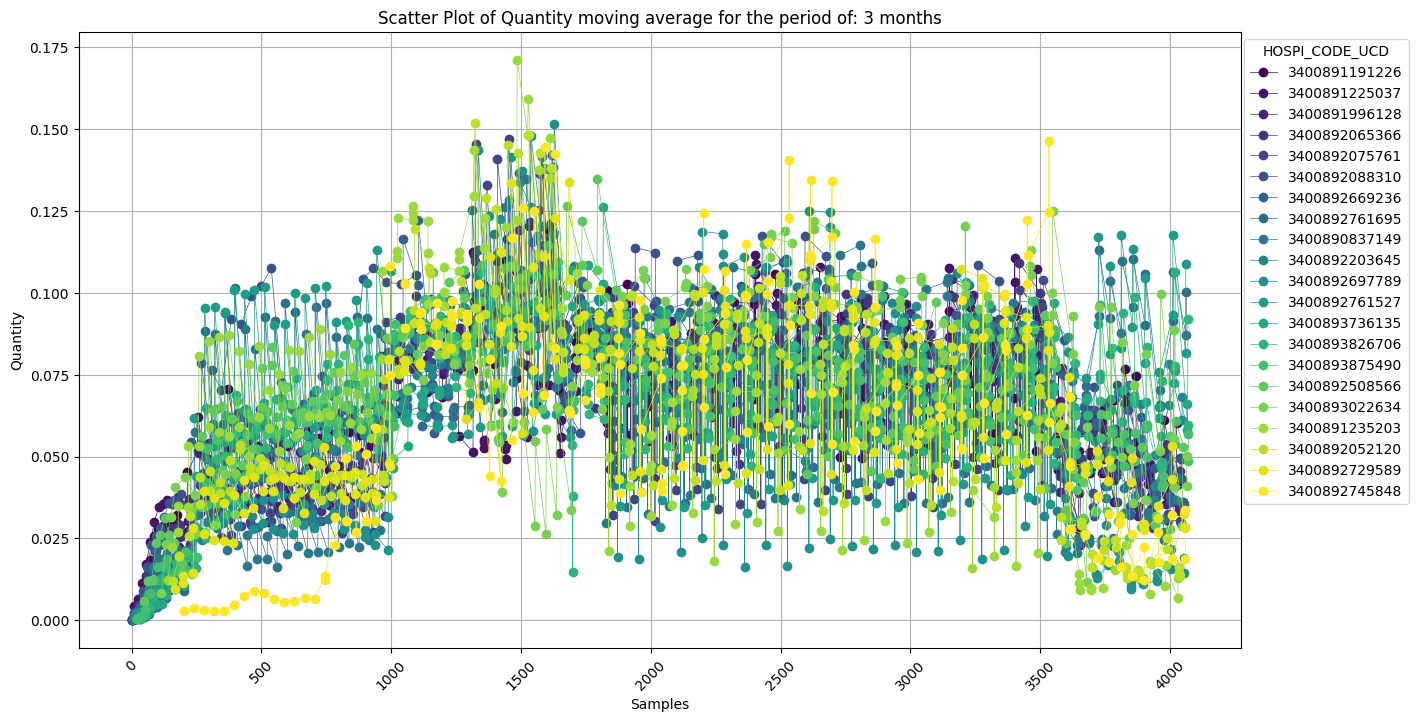

In [5]:
df_ma_3 = calculate_moving_average(df.copy(), 'QUANTITY', 3)
df_ma_3 = df_ma_3.sort_index(axis=1).reset_index(drop=True)
scatterplot_quantity(df_ma_3, 'QUANTITY_MA', 3)

In [6]:
month_dummies = pd.get_dummies(df_ma_3['MONTH'], prefix='MONTH')

df_encoded = pd.concat([df_ma_3, month_dummies], axis=1)
df_encoded = df_encoded.drop(['MONTH', 'ID_SITE_RATTACHE_NUM'], axis=1)

df_encoded.head()


,HOSPI_CODE_UCD,ID_SITE_RATTACHE_HOSPI_1,ID_SITE_RATTACHE_HOSPI_2,ID_SITE_RATTACHE_HOSPI_3,ID_SITE_RATTACHE_HOSPI_4,LIT_HC,LIT_HP,N_ETB,N_UFS,PN_MEDICAL,...,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12
0,3400891191226,1,0,0,0,1471.0,112.0,12.0,1.0,5270.0,...,0,0,0,1,0,0,0,0,0,0
1,3400891225037,1,0,0,0,1471.0,112.0,12.0,1.0,5270.0,...,0,0,0,1,0,0,0,0,0,0
2,3400891996128,1,0,0,0,1471.0,112.0,12.0,1.0,5270.0,...,0,0,0,1,0,0,0,0,0,0
3,3400892065366,1,0,0,0,1471.0,112.0,12.0,1.0,5270.0,...,0,0,0,1,0,0,0,0,0,0
4,3400892075761,1,0,0,0,1471.0,112.0,12.0,1.0,5270.0,...,0,0,0,1,0,0,0,0,0,0


## 3.2 - Correlation analysis

<Axes: >

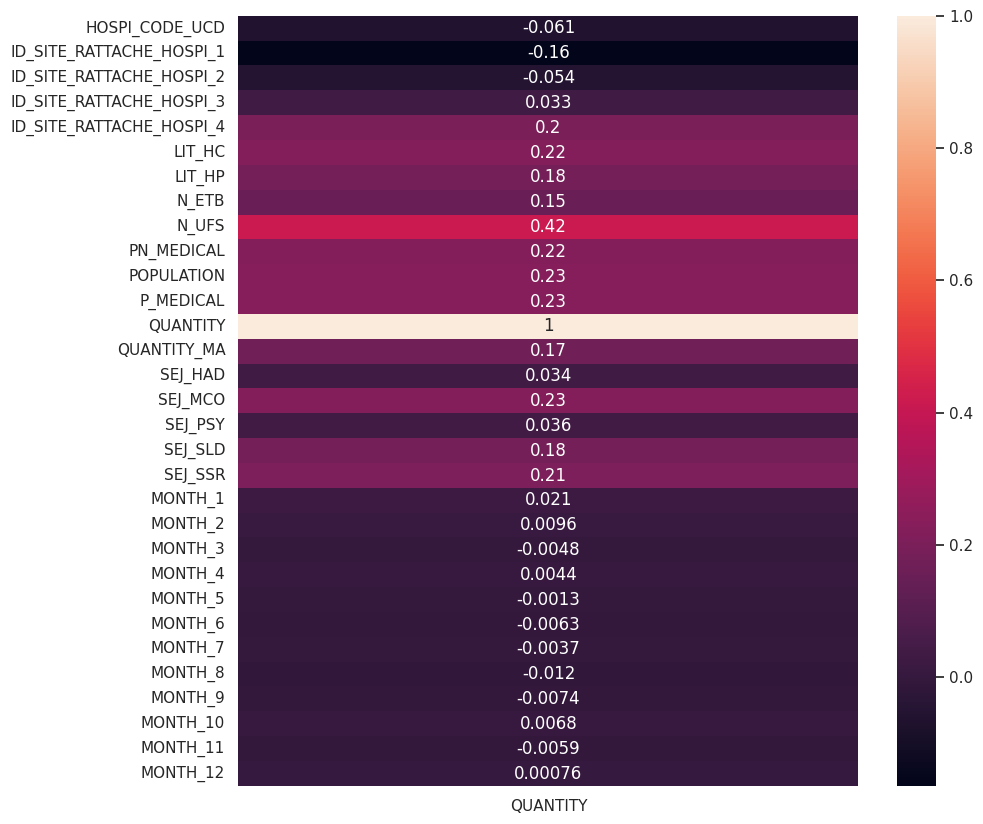

In [7]:
corr = df_encoded.corr(numeric_only=True)
x = corr[['QUANTITY']]
sns.set(rc={'figure.figsize':(10,10)})
sns.heatmap(x,annot=True)

<Axes: >

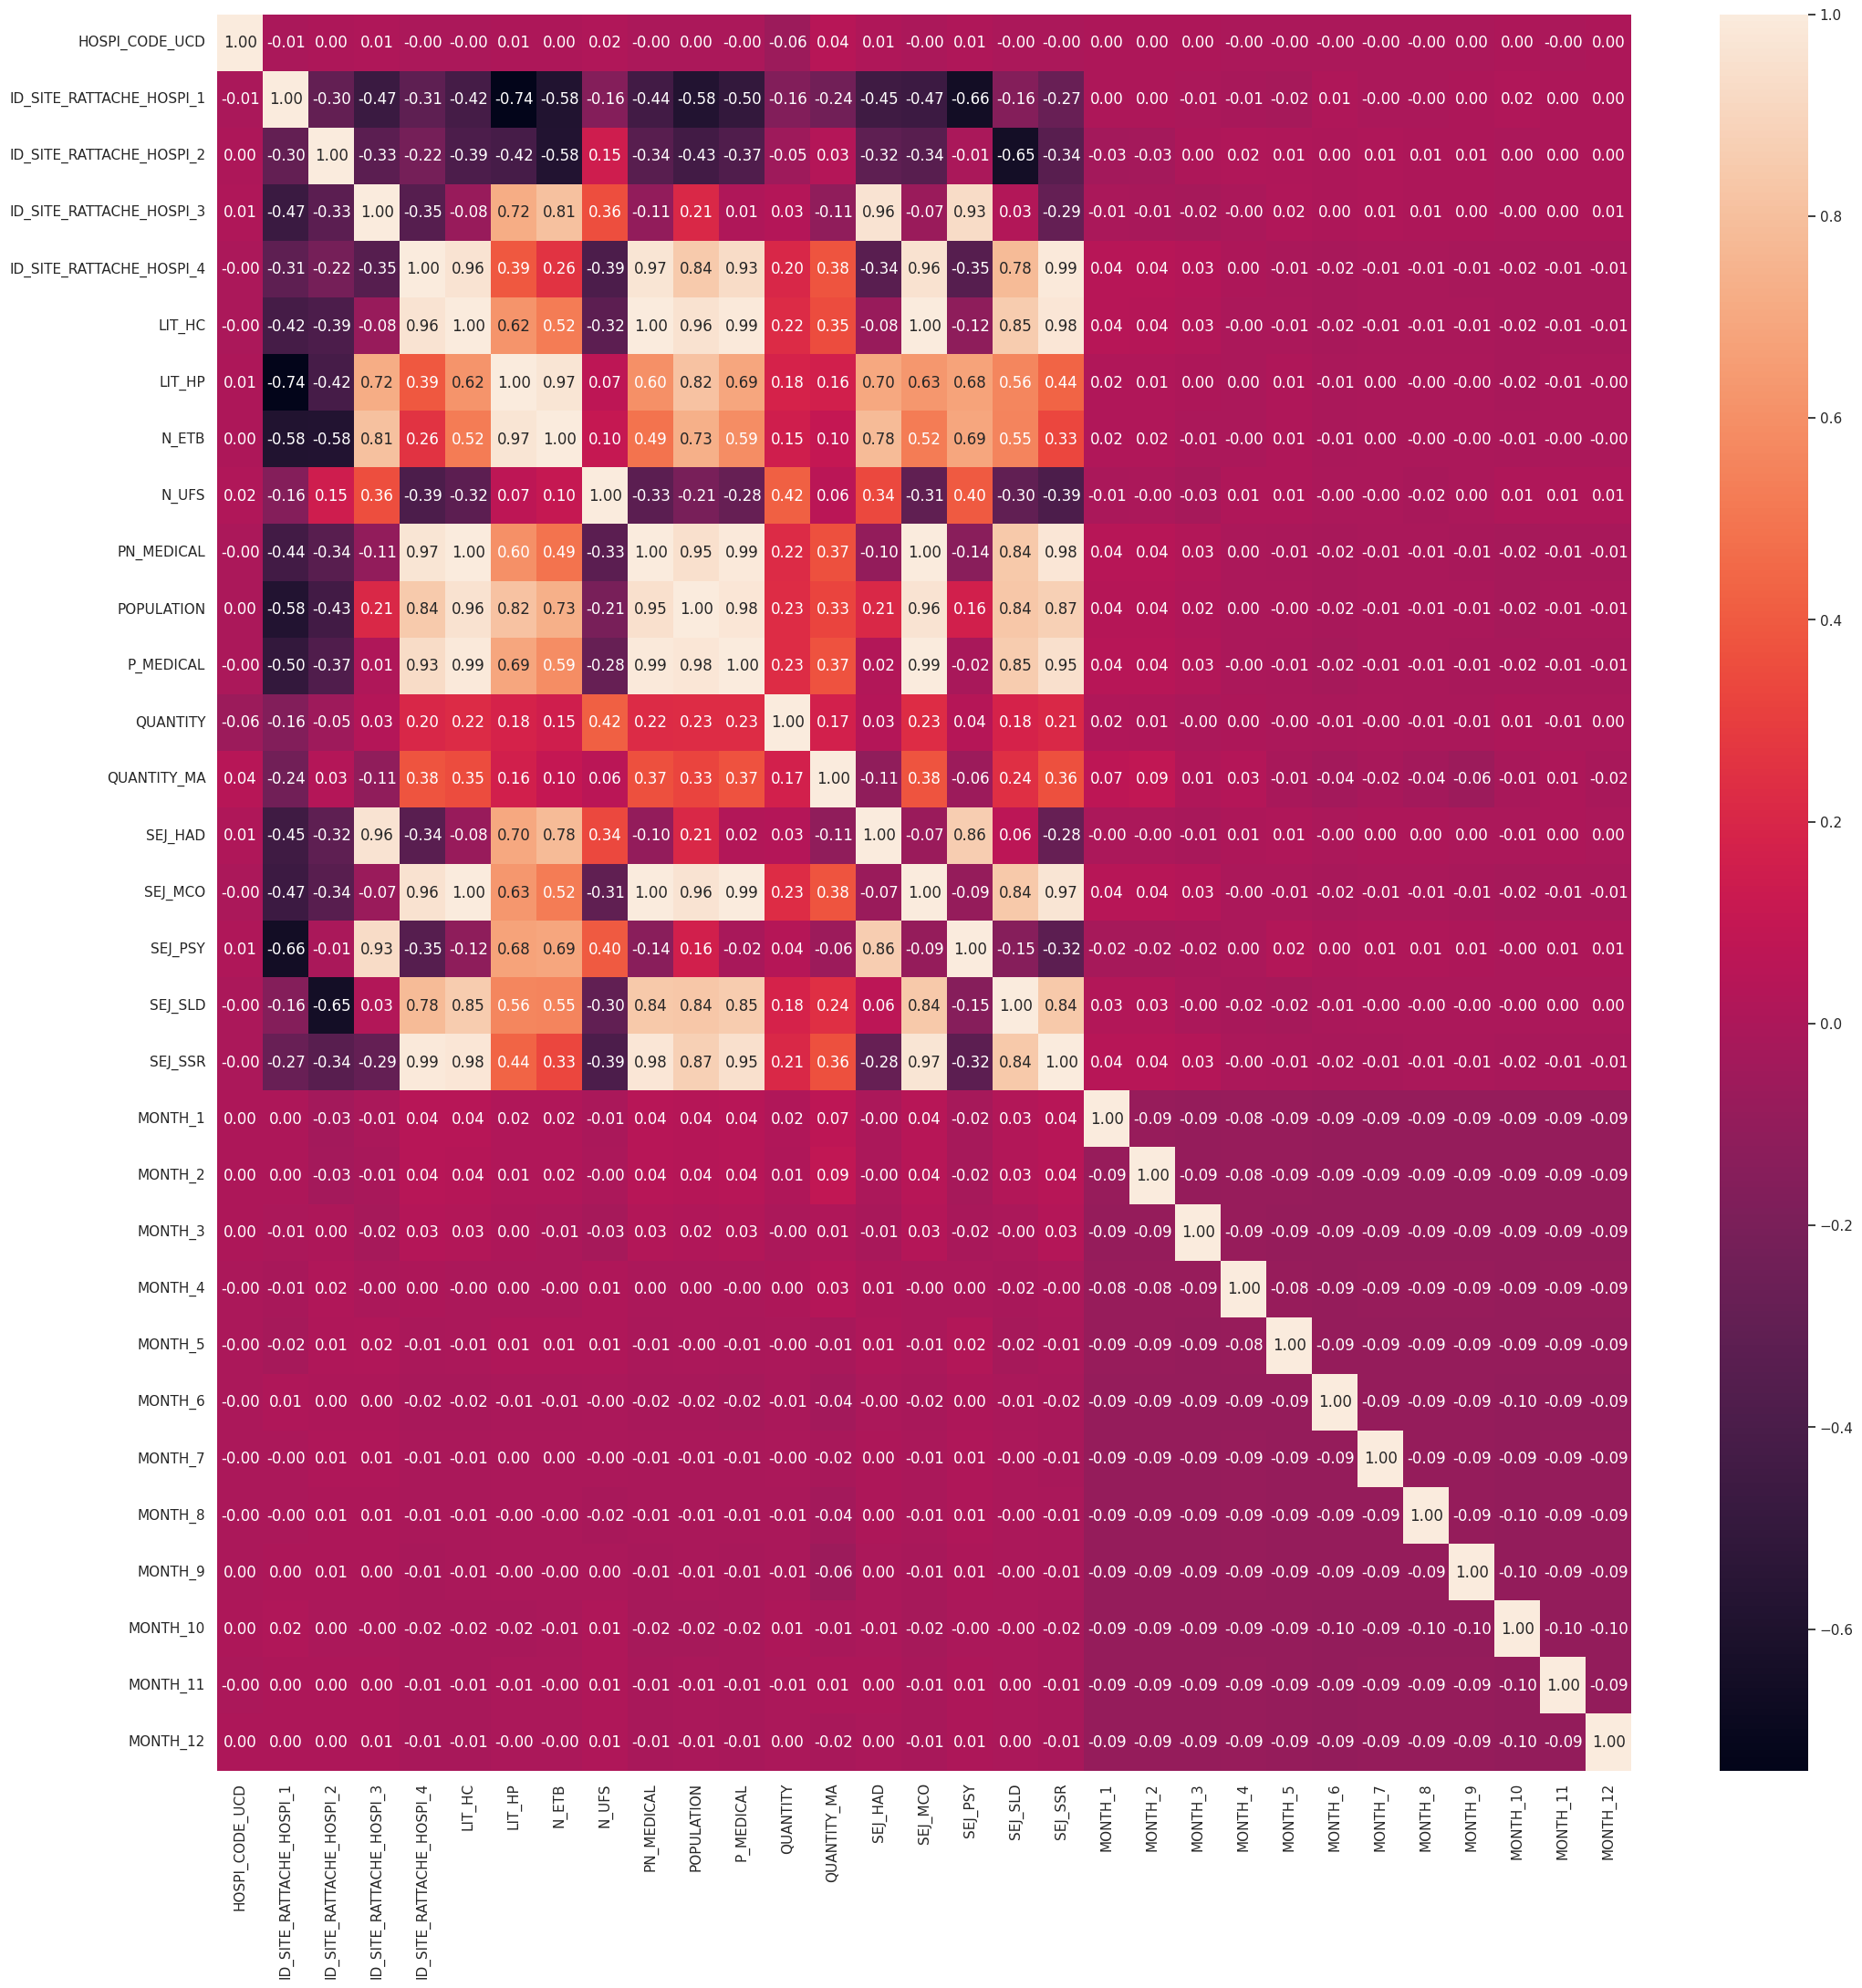

In [8]:

'''
  The constant values are not displayed in the correlation.
'''

corr = df_encoded.corr(numeric_only=True)
sns.set(rc={'figure.figsize': (25, 25)})
sns.heatmap(corr, annot=True, fmt='.2f')


## PCA

Principal component analysis (PCA).

Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space.


In Scikit-learn, [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) is applied using the PCA() class. It is in the decomposition submodule in Scikit-learn. The most important hyperparameter in that class is n_components.


The construction of relevant features is achieved by linearly transforming correlated variables into a smaller number of uncorrelated variables. This is done by projecting (dot product) the original data into the reduced PCA space using the eigenvectors of the covariance/correlation matrix aka the principal components (PCs). [[towards datascience](https://towardsdatascience.com/pca-clearly-explained-how-when-why-to-use-it-and-feature-importance-a-guide-in-python-7c274582c37e)]

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


X_scaled = StandardScaler().fit_transform(df_encoded.drop('HOSPI_CODE_UCD',axis=1).values)

pca_30 = PCA(n_components = X_scaled.shape[1], random_state = 42)
pca_30.fit(X_scaled)
X_pca_30 = pca_30.transform(X_scaled)

'''
  We can notice here that the first 6 components keep 99% of the variability
  in the dataset while reducing 12 features in the dataset.
'''

cumsum_X = np.cumsum(pca_30.explained_variance_ratio_)

In [18]:
import plotly.graph_objects as go

# Set the figure size to 12 by 12
fig = go.Figure()

fig.add_trace(go.Scatter(x=np.arange(len(cumsum_X)), y=cumsum_X, mode='lines'))
fig.update_xaxes(title='Number of components', tickvals=np.arange(0, len(cumsum_X), 2), ticktext=np.arange(0, len(cumsum_X), 2, dtype=int))
fig.update_yaxes(title='Explained variance [%]')
fig.update_layout(title="Cumulative Explained Variance Ratio by Number of Components", xaxis_type='category')

fig.show()


In [19]:
'''
  pca_95.get_params(deep=True)
  {'copy': True,
  'iterated_power': 'auto',
  'n_components': 0.95,
  'n_oversamples': 10,
  'power_iteration_normalizer': 'auto',
  'random_state': 42,
  'svd_solver': 'auto',
  'tol': 0.0,
  'whiten': False}

'''
pca_95 = PCA(n_components = 0.95, random_state = 42)
X_pca_95 = pca_95.fit_transform(X_scaled)
X_pca_95.shape

(4072, 15)

In [25]:
df_reduced = pd.DataFrame(X_pca_95,
                             columns = ['PC01','PC02','PC03','PC04','PC05',
                                        'PC06','PC07','PC08','PC09','PC10',
                                        'PC11','PC12','PC13','PC14','PC15',])
df_reduced.head()

,PC01,PC02,PC03,PC04,PC05,PC06,PC07,PC08,PC09,PC10,PC11,PC12,PC13,PC14,PC15
0,-2.541011,-1.725320,-2.294788,-0.127867,1.035832,-1.547113,2.725764,-0.388262,-0.630430,0.118966,0.382040,-0.061298,-0.303664,-0.047074,-0.042634
1,-2.541178,-1.725207,-2.295229,-0.127860,1.036241,-1.547145,2.725757,-0.388243,-0.630453,0.118989,0.382112,-0.061313,-0.303616,-0.047181,-0.042472
2,-2.540979,-1.725030,-2.294326,-0.125748,1.037214,-1.547285,2.725758,-0.388198,-0.630425,0.119146,0.382306,-0.061487,-0.303434,-0.047678,-0.041788
3,-2.540536,-1.725495,-2.293348,-0.126875,1.035360,-1.547108,2.725781,-0.388283,-0.630366,0.118987,0.381968,-0.061349,-0.303686,-0.047066,-0.042677
4,-2.539948,-1.725818,-2.291699,-0.126372,1.034281,-1.547042,2.725804,-0.388333,-0.630287,0.118950,0.381783,-0.061347,-0.303794,-0.046843,-0.043030


In [26]:
df_encoded.to_csv('df_ma.csv', index=False)
df_reduced.to_csv('df_reduced.csv', index = False)